# Makemore: Implement the paper MLP

Following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and [karpathy Andrej's](https://github.com/karpathy/makemore) repo, we try to implement the model step by step with the following

1. `makemore-practice-part1-paper-mlp`: 
    - Demonstration of how statisitcal models can be transform to scalable nn models. For example, bi-gram to nn from scratch.
2. `makemore-practice-part2-paper-mlp`: 
    - Implement nn from paper. 
    - Introduce basic concepts, for example embedding, tensor indexing, matrix operations, train-test-split,

In [2]:
import math
import os
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import torch

from graphviz import Digraph
from torch.nn import functional as F

os.chdir("/home/project")
%matplotlib inline
# graphviz.set_jupyter_format("svg")

## 1. Implement nn from Paper

- MLP: Implement the paper MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

     > In most experiments below, the neural network has one hidden layer beyond the word features
     > mapping, and optionally, direct connections from the word features to the output. Therefore there
     > are really two hidden layers: the shared word features layer C, which has no non-linearity (it would
     > not add anything useful), and the ordinary hyperbolic tangent hidden layer. More precisely, the
     > neural network computes the following function, with a softmax output layer, which guarantees
     > positive probabilities summing to 1



### 1. Build a naive semi-manuall network

**1.1 Model global settings**

In [3]:
size = 3

**1.2 Read and Prepare Data**

In [4]:
def read_txt(nrows: int = None):
    words = []
    with open("practice/makemore/name.txt", "r") as f:
        if nrows:
            for _ in range(nrows):
                words.append(f.readline().splitlines()[0])
        else:
            for line in f:
                words.append(line.splitlines()[0])
    return words


def get_lookup_map():
    lowercases = string.ascii_lowercase
    stoi = {s: i for i, s in enumerate(lowercases, start=1)}
    stoi["."] = 0
    itos = {val: key for key, val in stoi.items()}
    return stoi, itos


def preprocess(words: list, stoi: dict, size: int = 3):
    x, y = [], []
    for word in words:
        context = [0] * size
        for s in word + ".":
            idx = stoi[s]
            x.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return (x, y)


def train_eval_test_split(X: torch.tensor, Y: torch.tensor) -> torch.tensor:
    train_cnt = int(X.shape[0] * 0.8)
    test_cnt = int(X.shape[0] * 0.9)
    idx = torch.randperm(train_cnt)
    x_train, y_train = X[idx], Y[idx]
    x_eval, y_eval = X[train_cnt:test_cnt], Y[train_cnt:test_cnt]
    x_test, y_test = X[test_cnt:], Y[test_cnt:]
    return x_train, y_train, x_eval, y_eval, x_test, y_test


words = read_txt(None)
stoi, itos = get_lookup_map()
X, Y = preprocess(words=words[:], stoi=stoi, size=size)
x_train, y_train, x_eval, y_eval, x_test, y_test = train_eval_test_split(X, Y)
print(f"Rows: {len(words)}")
print(f"Top 5 rows: {words[:5]}")
print(stoi)
print(itos)
print(x_train[:5])
print(y_train[:5])
print(x_eval[:5])
print(y_eval[:5])

torch.Size([228146, 3]) torch.Size([228146])
Rows: 32033
Top 5 rows: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
tensor([[19,  9,  3],
        [ 0,  0,  1],
        [ 5,  5, 19],
        [20,  9,  3],
        [ 9,  5, 14]])
tensor([ 9, 18,  8,  5,  0])
tensor([[ 0,  0, 26],
        [ 0, 26, 21],
        [26, 21,  8],
        [21,  8,  1],
        [ 8,  1,  9]])
tensor([21,  8,  1,  9,  2])


**1.3 embedding, tensor indexing, matrix operations, train-test-split**

**slower examples than .view**

```python
tmp = C[torch.tensor([[0,0,0],[0,0,1]])]
torch.cat(torch.unbind(tmp, dim=1), dim=1)
torch.cat((tmp[:, 0, :], tmp[:, 1, :], tmp[:, 2, :]), dim=1)

```


In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((X.shape[1] * C.shape[1], 200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [8]:
sum([p.nelement() for p in parameters])

6881

In [9]:
loss_train, loss_eval, steps = [], [], []

**1.4 model fitting, mini-batch, stocastic gradient concept**

In [10]:
# embedding x @ C -> (data size, size) * (size, embedding size)
# We don't change to one_hot encoding since we notice the result stays the same due to the matrix multiplication
# turn one hot like [X, 27] @ [27, 2] becomes unnecessary
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

def train(mini_batch: int = 32):
    """model fitting

    Args:
        mini_batch (int, optional): _description_. Defaults to 32.

    Returns:
        _type_: _description_
    """

    for p in parameters:
        p.requires_grad = True

    for i in range(200000):
        ix = torch.randint(0, x_train.shape[0], (mini_batch,)) # mini-batch, stocastic gradient concept
        embedding = C[x_train[ix]]
        h = torch.tanh(embedding.view(-1, x_train.shape[1] * C.shape[1]) @ w1 + b1)
        logits = h @ w2 + b2
        loss = F.cross_entropy(logits, y_train[ix])

        for p in parameters:
            p.grad = None

        loss.backward()

        lr = 0.1 if i < 10000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

        loss_train.append(loss.log10().item())
        steps.append(i)

        if i % 10000 == 0:
            print(f"train loss: {loss}")

    print(f"train loss: {loss}")
    return loss_train, steps


def predict():
    for _ in range(20):
        out = []
        context = [0] * size
        while True:
            embedding = C[torch.tensor(context)]
            h1 = torch.tanh(embedding.view(1, -1) @ w1 + b1)
            logits = h1 @ w2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print("".join([itos[i] for i in out]))


loss_train, steps = train(mini_batch=64)

train loss: 22.363807678222656
train loss: 2.4846444129943848
train loss: 2.432525396347046
train loss: 2.2564423084259033
train loss: 2.2753093242645264
train loss: 2.442457437515259
train loss: 2.4400322437286377
train loss: 2.344353437423706
train loss: 2.595893144607544
train loss: 2.123338222503662
train loss: 2.1696715354919434
train loss: 2.035735845565796
train loss: 2.4063875675201416
train loss: 2.2033839225769043
train loss: 2.3062942028045654
train loss: 2.445643186569214
train loss: 2.3403263092041016
train loss: 2.366438627243042
train loss: 2.26045823097229
train loss: 2.3747286796569824
train loss: 2.1830456256866455


In [11]:
# training loss
emb = C[x_train]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, x_train.shape[1] * C.shape[1]) @ w1 + b1)  # (32, 100)
logits = h @ w2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.2785, grad_fn=<NllLossBackward0>)

In [12]:
# eval loss
emb = C[x_eval]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, x_eval.shape[1] * C.shape[1]) @ w1 + b1)  # (32, 100)
logits = h @ w2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_eval)
loss

tensor(2.5279, grad_fn=<NllLossBackward0>)

In [13]:
# test loss
emb = C[x_test]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, x_test.shape[1] * C.shape[1]) @ w1 + b1)  # (32, 100)
logits = h @ w2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_test)
loss

tensor(2.5319, grad_fn=<NllLossBackward0>)

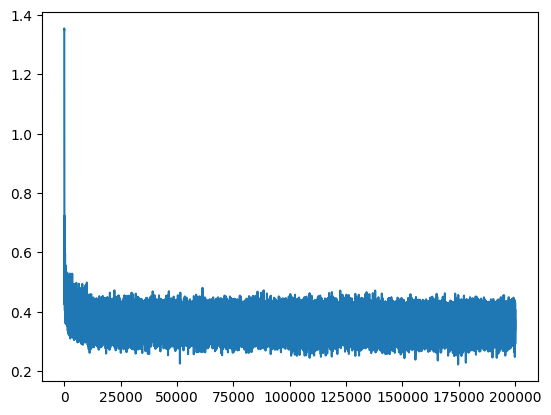

In [14]:
plt.plot(steps, loss_train)

**1.5 prediction**

In [73]:
predict()

magdimanoy.
ceenelob.
fynelyn.
lynn.
zaylaana.
maliannasree.
kayshi.
cay.
layrena.
japken.
ban.
suna.
brae.
kat.
ali.
jarya.
karishasheitharaya.
bhehann.
keae.
dha.


**1.6 learning weight visualization for model explanation**

In [54]:
# total_var = torch.var(C)
# U, S, V = torch.pca_lowrank(C, niter=5)
# pca_var = torch.var(V.view(-1))
# 100 * pca_var / total_var

In [55]:
# top_pca = C @ V[:, :2]

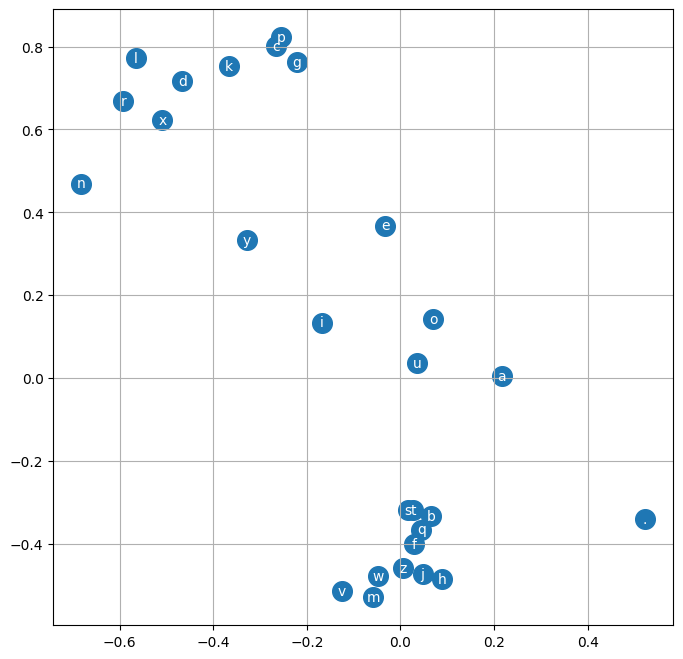

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')